<a href="https://colab.research.google.com/github/adeepH/DravidianOffensive/blob/main/Kannada/Pseudolabelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==3.3.1

In [2]:
!git clone https://github.com/adeepH/DravidianOffensive.git

fatal: destination path 'DravidianOffensive' already exists and is not an empty directory.


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

path = [] 
path_trans = []
root_path = '/content/DravidianOffensive/Datasets/'

train_ = root_path + 'kannada_offensive_train (1).csv'
test_ = root_path + 'kannada_offensive_test_with_labels.csv'
val_ = root_path + 'kannada_offensive_dev.csv'

trans_train_ =  root_path + 'Trans_kan_train.csv'
trans_test_ =  root_path + 'Trans_kan_test.csv'
trans_val_ =  root_path + 'Trans_kan_dev.csv'

path.append(train_)
path.append(val_)
path.append(test_)

path_trans.append(trans_train_)
path_trans.append(trans_test_)
path_trans.append(trans_val_)

def load_files(path):
    p = []
    for i in range(0,len(path)):
        p.append(pd.read_csv(path[i],header=None,names=['tweets','label'],sep="\t"))
        p[i]['labels'] = LabelEncoder().fit_transform(p[i]['label'])
        p[i] = p[i].drop(columns='label')
    return p[0],p[1],p[2]
from sklearn.preprocessing import LabelEncoder
train, val, test = load_files(path) 

In [4]:
import re
import string
def load_trans_files(path,word):
    p = []
    for i in range(0,len(path)):
        p.append(pd.read_csv(path[i], header=None, names=['tweet','label','tweets'],sep=","))
        p[i]['labels'] = LabelEncoder().fit_transform(p[i]['label'])
        p[i] = p[i].drop(columns=['label','tweet'])
        p[i] = p[i][0:] 
    for j in range(0,len(p[i])): 
        p[i]['tweets'][j] = re.sub(r'\+', '', p[i]['tweets'][j]) 
        p[i]['tweets'][j] = p[i]['tweets'][j].replace(word,' ') 
        p[i]['tweets'][j] = p[i]['tweets'][j].translate(str.maketrans('', '', string.punctuation)) 
    return p[0],p[1],p[2]
trans_train, trans_test,trans_val = load_trans_files(path_trans,'kn')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [5]:
df1 = train.append(val)
pseudo_train = df1.append(test)
df2 = trans_train.append(trans_test)
Trans = df2.append(trans_val)

In [6]:
pseudo_train.shape, Trans.shape

((7772, 2), (7772, 2))

In [7]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self,item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'label' : torch.tensor(label,dtype=torch.long)

    }

In [8]:
 
print('Training set size:',pseudo_train.shape)
#Uncomment the next line when we have the test data
#print('Testing set size:',test.shape)
print('Test set size:',Trans.shape)

Training set size: (7772, 2)
Test set size: (7772, 2)


In [9]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.labels.values),
                                                  train.labels.values)
class_weights

array([0.29237208, 3.14944276, 2.12765229, 8.42411924, 4.88757862,
       0.68079282])

In [10]:

def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = RFDataset(
      text = df.tweets.to_numpy(),
      label = df.labels.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers=2)

In [11]:
from transformers import AutoModel,AutoTokenizer
device = 'cuda'
PRE_TRAINED_MODEL_NAME = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [12]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(pseudo_train,tokenizer,MAX_LEN,BATCH_SIZE)
test_data_loader = create_data_loader(Trans,tokenizer,MAX_LEN,BATCH_SIZE)

In [13]:
BERT_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [14]:
import torch
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained('xlm-roberta-base')
    self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True)
    self.linear = nn.Linear(256*2, 128)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.4)
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    sequence_output, pooled_output = self.auto(input_ids, 
               attention_mask=attention_mask)

    # sequence_output has the following shape: (batch_size, sequence_length, 768)
    lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
    hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
    linear_output = self.linear(lstm_output[:,-1].view(-1,256*2)) ### assuming that you are only using the output of the last LSTM cell to perform classification

    return linear_output

In [15]:
model = RFClassifier(6)
model = model.to(device)

In [16]:
from transformers import AdamW, get_linear_schedule_with_warmup
EPOCHS =  5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [17]:

def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [18]:

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [19]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [20]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(pseudo_train)
  )
   
  
#  val_acc,val_loss = eval_model(
#      model,
#      val_data_loader,
#      loss_fn,
#      device,
#      len(val)
#  )
  
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
#  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
#  history['val_acc'].append(val_acc)
#  history['val_loss'].append(val_loss)



Epoch: 01 | Epoch Time: 5m 59s
Train Loss 1.3122877049347992 accuracy 0.6307256819351519

Epoch: 02 | Epoch Time: 5m 58s
Train Loss 0.9066834904774717 accuracy 0.6948018528049409

Epoch: 03 | Epoch Time: 5m 59s
Train Loss 0.8377638730247325 accuracy 0.7268399382398354

Epoch: 04 | Epoch Time: 5m 59s
Train Loss 0.7919039966638196 accuracy 0.7381626351003603

Epoch: 05 | Epoch Time: 5m 59s
Train Loss 0.7693027434525667 accuracy 0.7452393206381884



In [21]:
if train_acc > best_accuracy:
    torch.save(model.state_dict(),'xlm-pseudo-labelling_training.bin')
    best_accuracy = train_acc

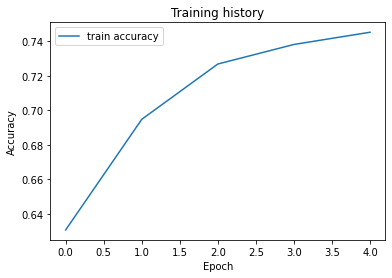

In [22]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
#plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([0, 1]);

In [23]:
val_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test_data_loader) #Change it to test when you have the test results
)
val_acc.item()

18.48971193415638

In [24]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [25]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [29]:
pseudo_labels = pd.DataFrame()
pseudo_labels['tweet'] = y_review_texts
pseudo_labels['label'] = y_pred
pseudo_labels.to_csv('pseudo_labels_xlm.csv')

In [27]:
class_name=['Not_offensive',
'not-Kannada',
'Offensive_Targeted_Insult_Individual',
'Offensive_Targeted_Insult_Group',          
'Offensive_Untargetede',                    
'Offensive_Targeted_Insult_Other']

In [28]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0))

ValueError: ignored

In [ ]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)